# Project: Adversarial BayesFlow - Experiment 1: MVN means
**Task:** Learn means of a 2-variate Gaussian with unit variance.

# Setup

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
import tensorflow as tf
import tensorflow_probability as tfp
import colorednoise as cn
from scipy import stats

import matplotlib.patches as  mpatches


from tqdm.notebook import tqdm

sys.path.append(os.path.abspath(os.path.join('../BayesFlow')))

from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.networks import InvertibleNetwork, InvariantNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.models import GenerativeModel
from bayesflow.exceptions import ConfigurationError
from bayesflow.applications.priors import GaussianMeanPrior, TPrior, GaussianMeanCovPrior
from bayesflow.applications.simulators import GaussianMeanSimulator, MultivariateTSimulator, GaussianMeanCovSimulator

from abf_functions import *

FILEFORMAT = 'png'
RERUN_GRID_EXPERIMENT = False

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices: 
    tf.config.experimental.set_memory_growth(device, True)

2021-10-29 19:55:06.725243: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set


In [3]:
D = 2
S_sufficient = 2
S_overcomplete = 4

## Define sufficient and overcomplete BayesFlow network

In [4]:
# Sufficient

#########

prior = GaussianMeanPrior(D=D)
simulator = GaussianMeanSimulator(D=D)
generative_model = GenerativeModel(prior, simulator)

#########

summary_meta = {
    'n_dense_s1': 2,
    'n_dense_s2': 2,
    'n_dense_s3': 2,
    'n_equiv':    1,
    'dense_s1_args': {'activation': 'relu', 'units': 32},
    'dense_s2_args': {'activation': 'relu', 'units': 32},
    'dense_s3_args': {'activation': 'relu', 'units': 32},
}

class BottleneckSummaryNet(tf.keras.Model):
    def __init__(self, inv_meta={}, n_out=10, activation_out=None):
        super(BottleneckSummaryNet, self).__init__()

        self.invariant_net = InvariantNetwork(inv_meta)
        self.out_layer = tf.keras.layers.Dense(n_out, activation=activation_out)
    
    def __call__(self, x):
        out_inv = self.invariant_net(x)
        out = self.out_layer(out_inv)
        return out


summary_net = BottleneckSummaryNet(inv_meta=summary_meta, 
                                   n_out=S_sufficient,
                                   activation_out=None  # linear
                                  )


inference_meta = {
    'n_coupling_layers': 2,
    's_args': {
        'units': [32, 32, 32],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [32, 32, 32],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': D,
    'alpha': 1.9,
    'permute': True
}

inference_net = InvertibleNetwork(inference_meta)

amortizer = SingleModelAmortizer(inference_net, summary_net)

trainer_sufficient = ParameterEstimationTrainer(amortizer,
                      generative_model,
                      loss=mmd_kl_loss,
                      learning_rate=0.0007,
                      checkpoint_path=f'export_ckpt/mmd/means_{D}D_sufficient',
                      max_to_keep = 1
                     )

2021-10-29 19:55:06.742449: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Networks loaded from export_ckpt/mmd/means_2D_sufficient/ckpt-50


In [5]:
#########

prior = GaussianMeanPrior(D=D)
simulator = GaussianMeanSimulator(D=D)
generative_model = GenerativeModel(prior, simulator)

#########

summary_meta = {
    'n_dense_s1': 2,
    'n_dense_s2': 2,
    'n_dense_s3': 2,
    'n_equiv':    1,
    'dense_s1_args': {'activation': 'relu', 'units': 32},
    'dense_s2_args': {'activation': 'relu', 'units': 32},
    'dense_s3_args': {'activation': 'relu', 'units': 32},
}

class BottleneckSummaryNet(tf.keras.Model):
    def __init__(self, inv_meta={}, n_out=10, activation_out=None):
        super(BottleneckSummaryNet, self).__init__()

        self.invariant_net = InvariantNetwork(inv_meta)
        self.out_layer = tf.keras.layers.Dense(n_out, activation=activation_out)
    
    def __call__(self, x):
        out_inv = self.invariant_net(x)
        out = self.out_layer(out_inv)
        return out


summary_net = BottleneckSummaryNet(inv_meta=summary_meta, 
                                   n_out=S_overcomplete,
                                   activation_out=None  # linear
                                  )


inference_meta = {
    'n_coupling_layers': 2,
    's_args': {
        'units': [32, 32, 32],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [32, 32, 32],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': D,
    'alpha': 1.9,
    'permute': True
}

inference_net = InvertibleNetwork(inference_meta)

amortizer = SingleModelAmortizer(inference_net, summary_net)

trainer_overcomplete = ParameterEstimationTrainer(amortizer,
                      generative_model,
                      loss=mmd_kl_loss,
                      learning_rate=0.0007,
                      checkpoint_path=f'export_ckpt/mmd/means_{D}D_overcomplete',
                      max_to_keep = 1
                     )

Networks loaded from export_ckpt/mmd/means_2D_overcomplete/ckpt-50


## Converge BayesFlow networks

In [ ]:
# losses = trainer_sufficient.train_rounds(epochs=10, rounds=5, sim_per_round=10000, batch_size=128, n_obs=100)

In [ ]:
# losses = trainer_overcomplete.train_rounds(epochs=10, rounds=5, sim_per_round=10000, batch_size=128, n_obs=100)

# Performance: Recover analytic Posterior

In [6]:
def calculate_analytic_posterior(prior, simulator, x):
    n_sim, n_obs, D = x.shape
    
    # Set up variables
    x_bar = np.mean(x, axis=1)                 # empirical mean
    sigma_0 = np.eye(D) * prior.mu_scale       # mu prior covariance
    sigma_0_inv = np.linalg.inv(sigma_0)       # inverse mu prior covariance
    mu_0 = np.ones((D, 1)) * prior.mu_mean     # mu prior mean
    sigma = simulator.sigma                    # likelihood covariance
    sigma_inv = np.linalg.inv(sigma)           # inverse likelihood covariance
    
    mu_posterior_covariance = np.stack([np.linalg.inv(sigma_0_inv + n_obs*sigma_inv)] * n_sim)
    
    mu_posterior_mean = mu_posterior_covariance @ (sigma_0_inv @ mu_0 + n_obs * (sigma_inv @ x_bar[..., np.newaxis]))   
    mu_posterior_mean = mu_posterior_mean.reshape(n_sim, D)

    return mu_posterior_mean, mu_posterior_covariance

In [7]:
def adversarial_diagnostics(trainer, generative_model, theta=None, x=None, filename=None):
    theta, x = generative_model(200, 100) if theta is None and x is None else (theta, x)
    param_samples = trainer.network.sample(x, n_samples=200)
    param_means = param_samples.mean(axis=0)

    # analytic posteriors
    print("\n\nBayesFlow (x) vs. analytic posterior means (y) -- Recovery of analytic posterior means")
    prior = trainer.generative_model.prior.__self__
    simulator = trainer.generative_model.simulator
    posterior_means, posterior_covariances = calculate_analytic_posterior(prior, simulator, x)
    posterior_variances = posterior_covariances.diagonal(axis1=1, axis2=2)
    
    true_vs_estimated(posterior_means, param_means, [r'$\mu_%i$'%i for i in range(1, D+1)], figsize=(8,4),
                          filename=f"{filename}_true_analytic.{FILEFORMAT}")

### Baseline: $\mathcal{M}_{obs} = \mathcal{M}^*$ 



BayesFlow (x) vs. analytic posterior means (y) -- Recovery of analytic posterior means


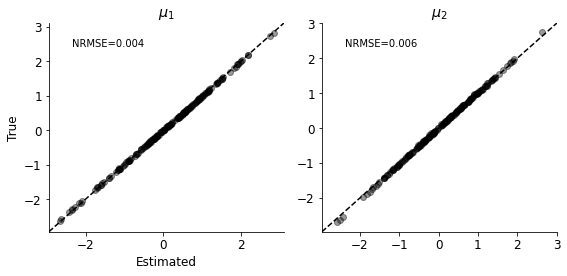

In [8]:
prior = GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1)
simulator = GaussianMeanSimulator(D=D)
generative_model = GenerativeModel(prior, simulator)
theta, x = generative_model(200,100)

adversarial_diagnostics(trainer_sufficient, generative_model, 
                        #print_plots=True,
                       filename=f"plots/abf_mvn_means_sufficient_baseline")



BayesFlow (x) vs. analytic posterior means (y) -- Recovery of analytic posterior means


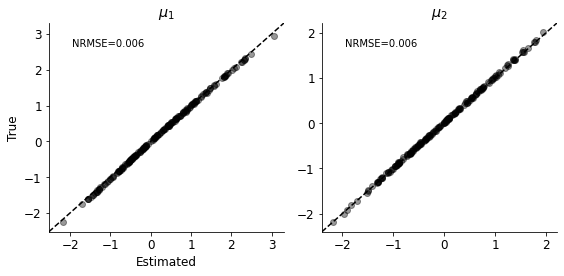

In [9]:
prior = GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1)
simulator = GaussianMeanSimulator(D=D)
generative_model = GenerativeModel(prior, simulator)
theta, x = generative_model(200,100)

adversarial_diagnostics(trainer_overcomplete, generative_model, 
                        #print_plots=True,
                       filename=f"plots/abf_mvn_means_overcomplete_baseline")

## Wrong Prior
The prior over the multivariate Gaussian's means is Gaussian: $\mu\sim\mathcal{N}(\mu|\mu_0, \Sigma_0)$

- Wrong (free) prior location and scale: $\mu\sim\mathcal{N}(\mu_0, \alpha_0\cdot\mathbb{I})$



BayesFlow (x) vs. analytic posterior means (y) -- Recovery of analytic posterior means


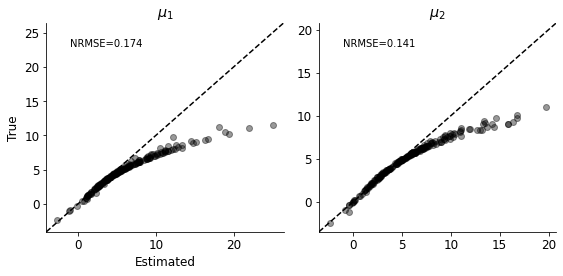

In [10]:
mu_0 = 5.0
alpha_0 = 2.5

prior = GaussianMeanPrior(D=D, mu_mean=mu_0, mu_scale=alpha_0)
simulator = GaussianMeanSimulator(D=D)
generative_model = GenerativeModel(prior, simulator)
theta, x = generative_model(200,100)

adversarial_diagnostics(trainer_sufficient, generative_model,  
                        #print_plots=True,
                       filename=f"plots/abf_mvn_means_sufficient_prior")



BayesFlow (x) vs. analytic posterior means (y) -- Recovery of analytic posterior means


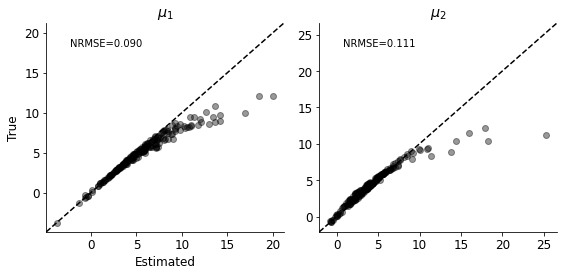

In [11]:
mu_0 = 5.0
alpha_0 = 2.5

prior = GaussianMeanPrior(D=D, mu_mean=mu_0, mu_scale=alpha_0)
simulator = GaussianMeanSimulator(D=D)
generative_model = GenerativeModel(prior, simulator)
theta, x = generative_model(200,100)

adversarial_diagnostics(trainer_overcomplete, generative_model,  
                        #print_plots=True,
                       filename=f"plots/abf_mvn_means_overcomplete_prior")

## (A2) Wrong Likelihood

$\boldsymbol{x}_k\sim \mathcal{N}(\boldsymbol{\mu}, \alpha\cdot\mathbb{I})$



BayesFlow (x) vs. analytic posterior means (y) -- Recovery of analytic posterior means


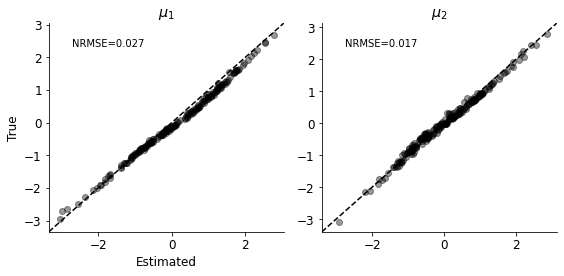

In [12]:
alpha = 10.0

prior = GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1)
simulator = GaussianMeanSimulator(D=D, s = alpha)
generative_model = GenerativeModel(prior, simulator)
theta, x = generative_model(200,100)

adversarial_diagnostics(trainer_sufficient, generative_model,  
                        #print_plots=True,
                       filename=f"plots/abf_mvn_means_sufficient_likelihood")



BayesFlow (x) vs. analytic posterior means (y) -- Recovery of analytic posterior means


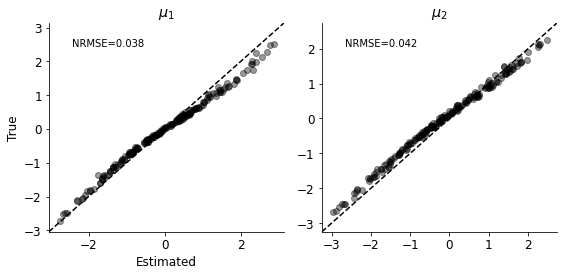

In [13]:
alpha = 10.0
prior = GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1)
simulator = GaussianMeanSimulator(D=D, s = alpha)
generative_model = GenerativeModel(prior, simulator)
theta, x = generative_model(200,100)

adversarial_diagnostics(trainer_overcomplete, generative_model,  
                        #print_plots=True,
                       filename=f"plots/abf_mvn_means_overcomplete_likelihood")

## (A3) Noise
$\mathbf{x}_k = \mathbf{x}_k + \xi$

In this scenario, the contamination $\xi$ is *pink noise* (aka $\frac{1}{f}$ noise) and added to the data $x$. The contaminated data is then normalized to obtain unit variance again.

$\tilde{x}=\dfrac{x+\xi}{\sigma_{x+\xi}}$ with $\xi \sim \frac{1}{f}$

In [14]:
import colorednoise as cn



BayesFlow (x) vs. analytic posterior means (y) -- Recovery of analytic posterior means


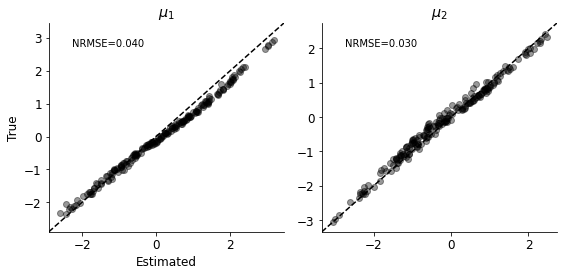

In [15]:
prior = GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1)
simulator = GaussianMeanSimulator(D=D)

generative_model = GenerativeModel(prior, simulator)
theta, x = generative_model(200, 100)

lamda = 5.0  # contribution of contamination xi 

xi = cn.powerlaw_psd_gaussian(exponent=1, size=x.shape)

x = x + lamda * normalize(xi)

adversarial_diagnostics(trainer_sufficient, generative_model=None, theta=theta, x=x,  
                        #print_plots=True,
                       filename=f"plots/abf_mvn_means_sufficient_noise")



BayesFlow (x) vs. analytic posterior means (y) -- Recovery of analytic posterior means


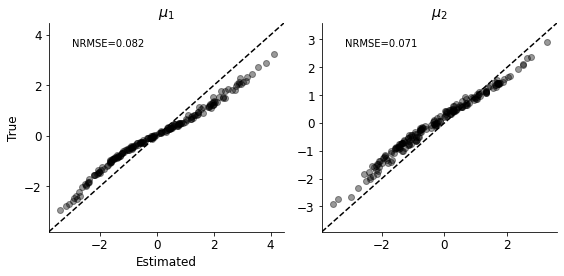

In [16]:
prior = GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1)
simulator = GaussianMeanSimulator(D=D)

generative_model = GenerativeModel(prior, simulator)
theta, x = generative_model(200, 100)

lamda = 5.0  # contribution of contamination xi 

xi = cn.powerlaw_psd_gaussian(exponent=1, size=x.shape)

x = x + lamda * normalize(xi)

adversarial_diagnostics(trainer_overcomplete, generative_model=None, theta=theta, x=x,  
                        #print_plots=True,
                       filename=f"plots/abf_mvn_means_overcomplete_noise")

# Summary space: MMD contour plots

## $\widehat{MMD}^2_u$ w.r.t. prior (location and scale factor)

In [17]:
# RERUN_GRID_EXPERIMENT = True

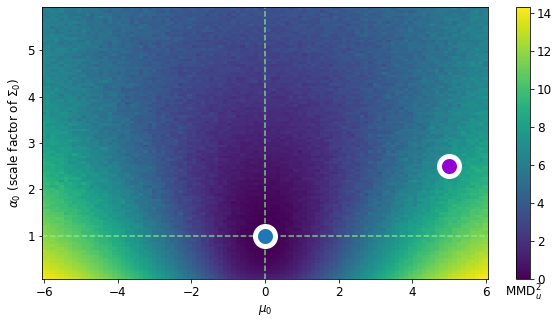

In [18]:
n_loc = 101
n_scale = 101
prior_loc = np.linspace(-6.0, 6.0, num = n_loc)
prior_scale = np.linspace(0.10, 5.90, num = n_scale)
P1, P2 = np.meshgrid(prior_loc, prior_scale)

if RERUN_GRID_EXPERIMENT:
    _, x_star = trainer_sufficient._forward_inference(200, 100)
    s_star = np.array(trainer_sufficient.network.summary_net(x_star))

    MMD = np.zeros((n_scale, n_loc))
    for i in tqdm(range(n_scale)):
        for j in range(n_loc):
            p1 = P1[i, j]
            p2 = P2[i, j]
            prior = GaussianMeanPrior(D=D, mu_mean=p1, mu_scale=p2)
            simulator = GaussianMeanSimulator(D=D)
            generative_model = GenerativeModel(prior, simulator)
            _, x_o = generative_model(200, 100)
            s_o = np.array(trainer_sufficient.network.summary_net(x_o))
            MMD[i, j] = float(maximum_mean_discrepancy(s_o, s_star, unbiased=True))
    np.save(f"data/MMD_grid_experiments/MVN_MMD_grid_sufficient_prior.npy", MMD)
    
MMD = np.load(f"data/MMD_grid_experiments/MVN_MMD_grid_sufficient_prior.npy")
plt.figure(figsize=(10, 5))
plt.pcolor(P1, P2, MMD, shading="nearest")
plt.xlabel(r"$\mu_0$")
plt.ylabel(r"$\alpha_0$ (scale factor of $\Sigma_0$)")
plt.axhline(y=1.0, linestyle="--", color="lightgreen", alpha=.80)
plt.axvline(x=0.0, linestyle="--", color="lightgreen", alpha=.80)

plt.plot(5, 2.5, linewidth=10, alpha=1.0, 
         marker="o", markersize=20, markeredgewidth=5.0, markeredgecolor="white", markerfacecolor = 'darkviolet'
        )
plt.plot(0, 1, linewidth=10, alpha=1.0, 
         marker="o", markersize=20, markeredgewidth=5.0, markeredgecolor="white", markerfacecolor = 'tab:blue'
        )

cbar = plt.colorbar()
cbar.ax.set_xlabel(r"MMD$^2_u$")
plt.savefig(f"plots/abf_mvn_means_sufficient_mmd_grid_prior.{FILEFORMAT}")

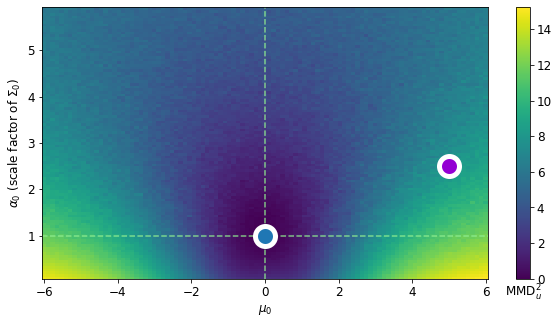

In [19]:
n_loc = 101
n_scale = 101
prior_loc = np.linspace(-6.0, 6.0, num = n_loc)
prior_scale = np.linspace(0.10, 5.90, num = n_scale)
P1, P2 = np.meshgrid(prior_loc, prior_scale)

if RERUN_GRID_EXPERIMENT:
    _, x_star = trainer_overcomplete._forward_inference(200, 100)
    s_star = np.array(trainer_overcomplete.network.summary_net(x_star))

    MMD = np.zeros((n_scale, n_loc))
    for i in tqdm(range(n_scale)):
        for j in range(n_loc):
            p1 = P1[i, j]
            p2 = P2[i, j]
            prior = GaussianMeanPrior(D=D, mu_mean=p1, mu_scale=p2)
            simulator = GaussianMeanSimulator(D=D)
            generative_model = GenerativeModel(prior, simulator)
            _, x_o = generative_model(200, 100)
            s_o = np.array(trainer_overcomplete.network.summary_net(x_o))
            MMD[i, j] = float(maximum_mean_discrepancy(s_o, s_star, unbiased=True))
    np.save(f"data/MMD_grid_experiments/MVN_MMD_grid_overcomplete_prior.npy", MMD)
    
MMD = np.load(f"data/MMD_grid_experiments/MVN_MMD_grid_overcomplete_prior.npy")
plt.figure(figsize=(10, 5))
plt.pcolor(P1, P2, MMD, shading="nearest")
plt.xlabel(r"$\mu_0$")
plt.ylabel(r"$\alpha_0$ (scale factor of $\Sigma_0$)")
plt.axhline(y=1.0, linestyle="--", color="lightgreen", alpha=.80)
plt.axvline(x=0.0, linestyle="--", color="lightgreen", alpha=.80)

plt.plot(5, 2.5, linewidth=10, alpha=1.0, 
         marker="o", markersize=20, markeredgewidth=5.0, markeredgecolor="white", markerfacecolor = 'darkviolet'
        )
plt.plot(0, 1, linewidth=10, alpha=1.0, 
         marker="o", markersize=20, markeredgewidth=5.0, markeredgecolor="white", markerfacecolor = 'tab:blue'
        )

cbar = plt.colorbar()
cbar.ax.set_xlabel(r"MMD$^2_u$")
plt.savefig(f"plots/abf_mvn_means_overcomplete_mmd_grid_prior.{FILEFORMAT}")

## $\widehat{MMD}^2_u$ w.r.t. likelihood and noise

In [20]:
from matplotlib.markers import MarkerStyle

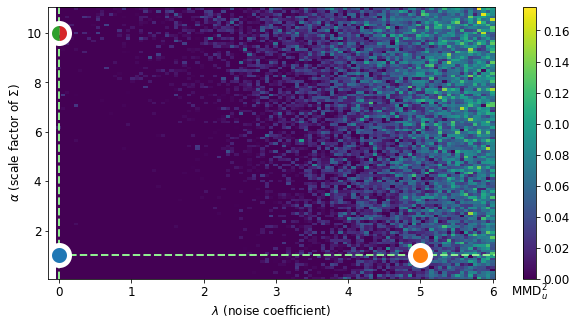

In [21]:
n_alpha = 101
n_lamda = 101
alpha_list = np.linspace(0.1, 11.0, num = n_alpha)
lamda_list = np.linspace(0.0, 6.0, num = n_lamda)

alpha_grid, lamda_grid = np.meshgrid(alpha_list, lamda_list)

if RERUN_GRID_EXPERIMENT:
    _, x = trainer_sufficient._forward_inference(200, 100)
    z_psi = np.array(trainer_sufficient.network.summary_net(x))

    MMD = np.zeros((n_lamda, n_alpha))
    for i in tqdm(range(n_lamda)):
        for j in range(n_alpha):
            alpha = alpha_grid[i, j]
            lamda = lamda_grid[i, j]
            prior = GaussianMeanPrior(D=D, mu_mean=0.0, mu_scale=1.0)
            simulator = GaussianMeanSimulator(D=D, s=alpha)
            generative_model = GenerativeModel(prior, simulator)
            _, x_o = generative_model(200, 100)

            xi = cn.powerlaw_psd_gaussian(exponent=1, size=x.shape)
            xi = normalize(xi)

            x_o = x_o + lamda * xi

            s_o = np.array(trainer_sufficient.network.summary_net(x_o))
            MMD[i, j] = float(maximum_mean_discrepancy(s_o, z_psi, unbiased=True))
    np.save(f"data/MMD_grid_experiments/MVN_MMD_grid_sufficient_likelihood_noise.npy", MMD)
    


MMD = np.load(f"data/MMD_grid_experiments/MVN_MMD_grid_sufficient_likelihood_noise.npy")
plt.figure(figsize=(10, 5))
plt.pcolor(lamda_list, alpha_list, MMD.T, shading="nearest")

plt.xlabel(r"$\lambda$ (noise coefficient)")
plt.ylabel(r"$\alpha$ (scale factor of $\Sigma$)")

plt.axvline(x=0.0, linestyle="--", color="lightgreen", alpha=1.00, linewidth=2)
plt.axhline(y=1.0, linestyle="--", color="lightgreen", alpha=1.00, linewidth=2)

plt.plot(5, 1, linewidth=10, alpha=1.0, 
         marker="o", markersize=20, markeredgewidth=5.0, markeredgecolor="white", markerfacecolor = 'tab:orange'
        )
plt.plot(0, 1, linewidth=10, alpha=1.0, 
         marker="o", markersize=20, markeredgewidth=5.0, markeredgecolor="white", markerfacecolor = 'tab:blue'
        )
plt.plot(0, 10, linewidth=10, alpha=1.0, 
         marker=MarkerStyle("o", fillstyle="right"), markersize=20, markeredgewidth=0, markeredgecolor="white", markerfacecolor = 'tab:red'
        )
plt.plot(0, 10, linewidth=10, alpha=1.0, 
         marker=MarkerStyle("o", fillstyle="left"), markersize=20, markeredgewidth=0, markeredgecolor="white", markerfacecolor = 'tab:green'
        )
plt.plot(0, 10, linewidth=10, alpha=1.0, 
         marker=MarkerStyle("o", fillstyle="none"), markersize=20, markeredgewidth=5.0, markeredgecolor="white", markerfacecolor = 'darkviolet'
        )
plt.xlim(-0.15)

cbar = plt.colorbar()
cbar.ax.set_xlabel(r"MMD$^2_u$")

plt.savefig(f"plots/abf_mvn_means_sufficient_mmd_grid_likelihood_noise.{FILEFORMAT}")

  0%|          | 0/101 [00:00<?, ?it/s]

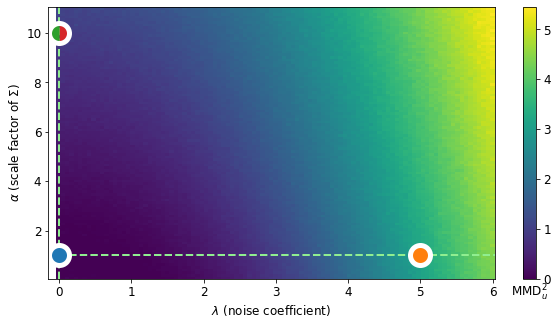

In [30]:
n_alpha = 101
n_lamda = 101
alpha_list = np.linspace(0.1, 11.0, num = n_alpha)
lamda_list = np.linspace(0.0, 6.0, num = n_lamda)

alpha_grid, lamda_grid = np.meshgrid(alpha_list, lamda_list)

if RERUN_GRID_EXPERIMENT:
    _, x = trainer_overcomplete._forward_inference(200, 100)
    z_psi = np.array(trainer_overcomplete.network.summary_net(x))

    MMD = np.zeros((n_lamda, n_alpha))
    for i in tqdm(range(n_lamda)):
        for j in range(n_alpha):
            alpha = alpha_grid[i, j]
            lamda = lamda_grid[i, j]
            prior = GaussianMeanPrior(D=D, mu_mean=0.0, mu_scale=1.0)
            simulator = GaussianMeanSimulator(D=D, s=alpha)
            generative_model = GenerativeModel(prior, simulator)
            _, x_o = generative_model(200, 100)

            xi = cn.powerlaw_psd_gaussian(exponent=1, size=x.shape)
            xi = normalize(xi)

            x_o = x_o + lamda * xi

            s_o = np.array(trainer_overcomplete.network.summary_net(x_o))
            MMD[i, j] = float(maximum_mean_discrepancy(s_o, z_psi, unbiased=True))
    np.save(f"data/MMD_grid_experiments/MVN_MMD_grid_overcomplete_likelihood_noise.npy", MMD)
    


MMD = np.load(f"data/MMD_grid_experiments/MVN_MMD_grid_overcomplete_likelihood_noise.npy")
plt.figure(figsize=(10, 5))
plt.pcolor(lamda_list, alpha_list, MMD.T, shading="nearest")

plt.xlabel(r"$\lambda$ (noise coefficient)")
plt.ylabel(r"$\alpha$ (scale factor of $\Sigma$)")

plt.axvline(x=0.0, linestyle="--", color="lightgreen", alpha=1.00, linewidth=2)
plt.axhline(y=1.0, linestyle="--", color="lightgreen", alpha=1.00, linewidth=2)

plt.plot(5, 1, linewidth=10, alpha=1.0, 
         marker="o", markersize=20, markeredgewidth=5.0, markeredgecolor="white", markerfacecolor = 'tab:orange'
        )
plt.plot(0, 1, linewidth=10, alpha=1.0, 
         marker="o", markersize=20, markeredgewidth=5.0, markeredgecolor="white", markerfacecolor = 'tab:blue'
        )
plt.plot(0, 10, linewidth=10, alpha=1.0, 
         marker=MarkerStyle("o", fillstyle="right"), markersize=20, markeredgewidth=0, markeredgecolor="white", markerfacecolor = 'tab:red'
        )
plt.plot(0, 10, linewidth=10, alpha=1.0, 
         marker=MarkerStyle("o", fillstyle="left"), markersize=20, markeredgewidth=0, markeredgecolor="white", markerfacecolor = 'tab:green'
        )
plt.plot(0, 10, linewidth=10, alpha=1.0, 
         marker=MarkerStyle("o", fillstyle="none"), markersize=20, markeredgewidth=5.0, markeredgecolor="white", markerfacecolor = 'darkviolet'
        )
plt.xlim(-0.15)

cbar = plt.colorbar()
cbar.ax.set_xlabel(r"MMD$^2_u$")

plt.savefig(f"plots/abf_mvn_means_overcomplete_mmd_grid_likelihood_noise.{FILEFORMAT}")

# Summary Space Pairplots

## Pairplot sufficient

In [ ]:
n_sim = 1000

# No MMS
_, x_no_MMS = GenerativeModel(
    GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1), 
    GaussianMeanSimulator(D=D))(n_sim, 100)

# Prior MMS
_, x_prior_MMS = GenerativeModel(
    GaussianMeanPrior(D=D, mu_mean=5, mu_scale=2.5), 
    GaussianMeanSimulator(D=D))(n_sim, 100)

_, x_simulator_MMS = GenerativeModel(
    GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1), 
    GaussianMeanSimulator(D=D, s=10.0))(n_sim, 100)

_, x_noise_MMS = GenerativeModel(
    GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1), 
    GaussianMeanSimulator(D=D))(n_sim, 100)
x_noise_MMS += 5.0 * normalize(cn.powerlaw_psd_gaussian(exponent=1, size=x_no_MMS.shape))

s_no_MMS = np.array(trainer_sufficient.network.summary_net(x_no_MMS))
s_prior_MMS = np.array(trainer_sufficient.network.summary_net(x_prior_MMS))
s_simulator_MMS = np.array(trainer_sufficient.network.summary_net(x_simulator_MMS))
s_noise_MMS = np.array(trainer_sufficient.network.summary_net(x_noise_MMS))

In [ ]:
TASK_NAMES = ['Prior', 'Simulator', 'Noise', 'No MMS']
S_ALL = [s_prior_MMS, s_simulator_MMS, s_noise_MMS, s_no_MMS]
DF = (pd.DataFrame(s, columns=[r'$s_{%i}$'%i for i in range(1, S_sufficient+1)]) for s in S_ALL)

df = pd.concat(DF,
              keys=TASK_NAMES,
              names=['MMS', None]
              ).reset_index(level=0)

In [ ]:
def plot_subset(x, y, hue, mask, **kws):
    sns.kdeplot(x=x[mask], y=y[mask], hue=hue[mask], fill=True, levels=10, **kws)

g = sns.PairGrid(df, hue="MMS", height=3, palette=['darkviolet', 'tab:green', 'tab:orange', 'tab:blue'])

g.map_diag(sns.kdeplot)

g.map_lower(plot_subset, mask= 
            (
                (df["MMS"] == 'Prior') |
                (df["MMS"] == 'Noise') |
                (df["MMS"] == 'No MMS')
           )
           )


g.map_upper(plot_subset, mask= 
            (
                (df["MMS"] == 'Simulator') |
                (df["MMS"] == 'No MMS')
           )
           )

handles = [mpatches.Patch(facecolor="tab:blue", label="No MMS"),
           mpatches.Patch(facecolor="darkviolet", label="Prior"),
           mpatches.Patch(facecolor="tab:orange", label="Noise"),
           mpatches.Patch(facecolor="tab:green", label=r"Simulator"),
           ]
plt.legend(handles=handles, loc="upper center", ncol=4, bbox_to_anchor=(-1.9, -1.3), title="", fontsize=20)

for ax in g.axes.flatten():
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    
#g.add_legend(loc="upper center", ncol=5, bbox_to_anchor=(0.35, 0), title="", label_order=['No MMS', 'Prior',  'Noise', 'Simulator S5', 'Simulator S10 PCA'])
#plt.setp(g._legend.get_texts(), fontsize=20)
#for legobj in g.legend.legendHandles:
#    legobj.set_linewidth(12.0)


#legend_dict = g._legend_data
#upper_legend_keys = ["No MMS", 'Simulator S5', "Simulator S10 PCA"]
#lower_legend_keys = ["No MMS", "Prior", "Noise"]

#l1 = g.fig.legend({key: legend_dict[key] for key in upper_legend_keys},
    #loc="upper right", ncol=3, fontsize=20, bbox_to_anchor=(0.90, 1.05))
#l2 = g.fig.legend({key: legend_dict[key] for key in lower_legend_keys},
    #loc="upper center", ncol=3, fontsize=20, bbox_to_anchor=(0.30, 0))

plt.savefig("plots/abf_mvn_means_pairplot_sufficient.png", bbox_inches="tight")

## Pairplot overcomplete

In [ ]:
n_sim = 1000

# No MMS
_, x_no_MMS = GenerativeModel(
    GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1), 
    GaussianMeanSimulator(D=D))(n_sim, 100)

# Prior MMS
_, x_prior_MMS = GenerativeModel(
    GaussianMeanPrior(D=D, mu_mean=5, mu_scale=2.5), 
    GaussianMeanSimulator(D=D))(n_sim, 100)

_, x_simulator_MMS = GenerativeModel(
    GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1), 
    GaussianMeanSimulator(D=D, s=10.0))(n_sim, 100)

_, x_noise_MMS = GenerativeModel(
    GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1), 
    GaussianMeanSimulator(D=D))(n_sim, 100)
x_noise_MMS += 5.0 * normalize(cn.powerlaw_psd_gaussian(exponent=1, size=x_no_MMS.shape))

s_no_MMS = np.array(trainer_overcomplete.network.summary_net(x_no_MMS))
s_prior_MMS = np.array(trainer_overcomplete.network.summary_net(x_prior_MMS))
s_simulator_MMS = np.array(trainer_overcomplete.network.summary_net(x_simulator_MMS))
s_noise_MMS = np.array(trainer_overcomplete.network.summary_net(x_noise_MMS))

In [ ]:
TASK_NAMES = ['Prior', 'Simulator', 'Noise', 'No MMS']
S_ALL = [s_prior_MMS, s_simulator_MMS, s_noise_MMS, s_no_MMS]
DF = (pd.DataFrame(s, columns=[r'$s_{%i}$'%i for i in range(1, S_overcomplete+1)]) for s in S_ALL)

df = pd.concat(DF,
              keys=TASK_NAMES,
              names=['MMS', None]
              ).reset_index(level=0)

In [ ]:
def plot_subset(x, y, hue, mask, **kws):
    sns.kdeplot(x=x[mask], y=y[mask], hue=hue[mask], fill=True, levels=10, **kws)

g = sns.PairGrid(df, hue="MMS", height=3, palette=['darkviolet', 'tab:green', 'tab:orange', 'tab:blue'])

g.map_diag(sns.kdeplot)

g.map_lower(plot_subset, mask= 
            (
                (df["MMS"] == 'Prior') |
                (df["MMS"] == 'Noise') |
                (df["MMS"] == 'No MMS')
           )
           )


g.map_upper(plot_subset, mask= 
            (
                (df["MMS"] == 'Simulator') |
                (df["MMS"] == 'No MMS')
           )
           )

handles = [mpatches.Patch(facecolor="tab:blue", label="No MMS"),
           mpatches.Patch(facecolor="darkviolet", label="Prior"),
           mpatches.Patch(facecolor="tab:orange", label="Noise"),
           mpatches.Patch(facecolor="tab:green", label=r"Simulator"),
           ]
plt.legend(handles=handles, loc="upper center", ncol=4, bbox_to_anchor=(-1.9, -1.3), title="", fontsize=20)

for ax in g.axes.flatten():
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    
#g.add_legend(loc="upper center", ncol=5, bbox_to_anchor=(0.35, 0), title="", label_order=['No MMS', 'Prior',  'Noise', 'Simulator S5', 'Simulator S10 PCA'])
#plt.setp(g._legend.get_texts(), fontsize=20)
#for legobj in g.legend.legendHandles:
#    legobj.set_linewidth(12.0)


#legend_dict = g._legend_data
#upper_legend_keys = ["No MMS", 'Simulator S5', "Simulator S10 PCA"]
#lower_legend_keys = ["No MMS", "Prior", "Noise"]

#l1 = g.fig.legend({key: legend_dict[key] for key in upper_legend_keys},
    # loc="upper right", ncol=3, fontsize=20, bbox_to_anchor=(0.90, 1.05))
#l2 = g.fig.legend({key: legend_dict[key] for key in lower_legend_keys},
    # loc="upper center", ncol=3, fontsize=20, bbox_to_anchor=(0.30, 0))

plt.savefig(f"plots/abf_mvn_means_overcomplete_pairplot.{FILEFORMAT}", bbox_inches="tight")   ## bbox tight    # tiff oder pdf, dpi > 300

# Wrongness: MMD vs. Posterior Error

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [24]:
def calculate_analytic_posterior(prior, simulator, x):
    n_sim, n_obs, D = x.shape

    # Set up variables
    x_bar = np.mean(x, axis=1)                 # empirical mean
    sigma_0 = np.eye(D) * prior.mu_scale       # mu prior covariance
    sigma_0_inv = np.linalg.inv(sigma_0)       # inverse mu prior covariance
    mu_0 = np.ones((D, 1)) * prior.mu_mean     # mu prior mean
    sigma = simulator.sigma                    # likelihood covariance
    sigma_inv = np.linalg.inv(sigma)           # inverse likelihood covariance

    mu_posterior_covariance = np.stack([np.linalg.inv(sigma_0_inv + n_obs*sigma_inv)] * n_sim)

    mu_posterior_mean = mu_posterior_covariance @ (sigma_0_inv @ mu_0 + n_obs * (sigma_inv @ x_bar[..., np.newaxis]))   
    mu_posterior_mean = mu_posterior_mean.reshape(n_sim, D)

    return mu_posterior_mean, mu_posterior_covariance


In [27]:
def MMD_error_analysis_prior_MMS(trainer, n_sim=1000, n_steps=1000, n_posterior_samples=1000):
        
    _, x_star = trainer._forward_inference(n_sim, 100)
    s_star = trainer.network.summary_net(x_star)

    alpha_0_min, alpha_0_max = 0.0, 2.5
    mu_0_min, mu_0_max = 0.0, 5.0
    b = np.linspace(0, 1, num = n_steps)

    mu_0_list = mu_0_min + b * (mu_0_max - mu_0_min)
    alpha_0_list = alpha_0_min + b * (alpha_0_max - alpha_0_min)

    MMD = np.empty_like(b)
    MAE_mean = np.empty_like(b)
    RMSE_mean = np.empty_like(b)
    
    MAE_Q25 = np.empty_like(b)
    RMSE_Q25 = np.empty_like(b)
    
    MAE_Q75 = np.empty_like(b)
    RMSE_Q75 = np.empty_like(b)

    for i in tqdm(range(len(b))):
        prior = GaussianMeanPrior(D=D, mu_mean=mu_0_list[i], mu_scale=alpha_0_list[i])
        simulator = GaussianMeanSimulator(D=D)
        generative_model = GenerativeModel(prior, simulator)
        theta, x = generative_model(n_sim,100)
        s = trainer.network.summary_net(x)

        MMD[i] = maximum_mean_discrepancy(s, s_star, unbiased=True)

        theta_est_samples = trainer.network.sample(x, n_samples=n_posterior_samples)


        prior = trainer.generative_model.prior.__self__
        simulator = trainer.generative_model.simulator
        posterior_mean, posterior_covariance = calculate_analytic_posterior(prior, simulator, x)
        posterior_sd = np.sqrt(posterior_covariance.diagonal(axis1=1, axis2=2))

        theta_mean = theta_est_samples.mean(axis=0)

        theta_Q25 = np.quantile(theta_est_samples, .25, axis=0)
        posterior_Q25 = posterior_mean - .674 * posterior_sd
            
        theta_Q75 = np.quantile(theta_est_samples, .75, axis=0)
        posterior_Q75 = posterior_mean + .674 * posterior_sd

        MAE_mean[i] = mean_absolute_error(theta_mean, posterior_mean)
        RMSE_mean[i] = mean_squared_error(theta_mean, posterior_mean, squared=False)
        
        MAE_Q25[i] = mean_absolute_error(theta_Q25, posterior_Q25)
        RMSE_Q25[i] = mean_squared_error(theta_Q25, posterior_Q25, squared=False)
        
        MAE_Q75[i] = mean_absolute_error(theta_Q75, posterior_Q75)
        RMSE_Q75[i] = mean_squared_error(theta_Q75, posterior_Q75, squared=False)
        
        


    idx = np.argsort(MMD)

    MMD = MMD[idx]
    
    MAE_mean = MAE_mean[idx]
    RMSE_mean = RMSE_mean[idx]
    
    MAE_Q25 = MAE_Q25[idx]
    RMSE_Q25 = RMSE_Q25[idx]
    
    MAE_Q75 = MAE_Q75[idx]
    RMSE_Q75 = RMSE_Q75[idx]
    
    return MMD, MAE_mean, RMSE_mean, MAE_Q25, RMSE_Q25, MAE_Q75, RMSE_Q75

## MMD-Error Sufficient

In [49]:
MMD_sufficient, MAE_sufficient_mean, RMSE_sufficient_mean, MAE_sufficient_Q25, RMSE_sufficient_Q25, MAE_sufficient_Q75, RMSE_sufficient_Q75 = MMD_error_analysis_prior_MMS(trainer_sufficient)


np.save("data/MMD_Error/MMD_sufficient.npy", MMD_sufficient)
np.save("data/MMD_Error/MAE_sufficient_mean.npy", MAE_sufficient_mean)
np.save("data/MMD_Error/RMSE_sufficient_mean.npy", RMSE_sufficient_mean)
np.save("data/MMD_Error/MAE_sufficient_Q25.npy", MAE_sufficient_Q25)
np.save("data/MMD_Error/RMSE_sufficient_Q25.npy", RMSE_sufficient_Q25)
np.save("data/MMD_Error/MAE_sufficient_Q75.npy", MAE_sufficient_Q75)
np.save("data/MMD_Error/RMSE_sufficient_Q75.npy", RMSE_sufficient_Q75)

  0%|          | 0/1000 [00:00<?, ?it/s]

## MMD--Error Overcomplete

In [50]:
MMD_overcomplete, MAE_overcomplete_mean, RMSE_overcomplete_mean, MAE_overcomplete_Q25, RMSE_overcomplete_Q25, MAE_overcomplete_Q75, RMSE_overcomplete_Q75 = MMD_error_analysis_prior_MMS(trainer_overcomplete)

np.save("data/MMD_Error/MMD_overcomplete.npy", MMD_overcomplete)
np.save("data/MMD_Error/MAE_overcomplete_mean.npy", MAE_overcomplete_mean)
np.save("data/MMD_Error/RMSE_overcomplete_mean.npy", RMSE_overcomplete_mean)
np.save("data/MMD_Error/MAE_overcomplete_Q25.npy", MAE_overcomplete_Q25)
np.save("data/MMD_Error/RMSE_overcomplete_Q25.npy", RMSE_overcomplete_Q25)
np.save("data/MMD_Error/MAE_overcomplete_Q75.npy", MAE_overcomplete_Q75)
np.save("data/MMD_Error/RMSE_overcomplete_Q75.npy", RMSE_overcomplete_Q75)

  0%|          | 0/1000 [00:00<?, ?it/s]

## Plots

In [51]:
def plot_MMD_error(trainer_suffix, exp_suffix, ylab):
    MMD = np.load(f"data/MMD_Error/MMD_{trainer_suffix}.npy")
    MAE = np.load(f"data/MMD_Error/MAE_{trainer_suffix}_{exp_suffix}.npy")
    RMSE = np.load(f"data/MMD_Error/RMSE_{trainer_suffix}_{exp_suffix}.npy")

    plt.figure(figsize=(6,4))
    plt.plot(MMD, MAE, label="MAE")
    plt.plot(MMD, RMSE, label="RMSE")

    plt.title(f"{trainer_suffix}, Posterior {exp_suffix}")
    plt.xlabel(r"$\widehat{MMD}^2_u$")
    plt.ylabel(ylab)
    plt.xlim(0)
    plt.legend()

    plt.savefig(f"plots/abf_mvn_means_{trainer_suffix}_{exp_suffix}_MMD_Error.{FILEFORMAT}", bbox_inches="tight")

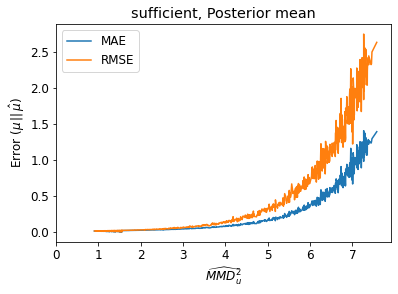

In [52]:
plot_MMD_error("sufficient", "mean", ylab=r"Error ($\mu\,||\,\hat{\mu})$")

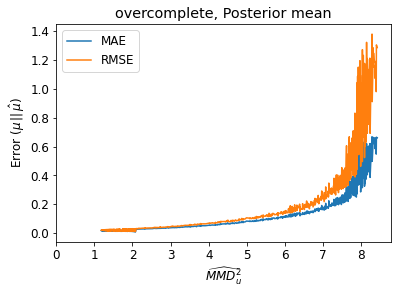

In [53]:
plot_MMD_error("overcomplete", "mean", ylab=r"Error ($\mu\,||\,\hat{\mu})$")

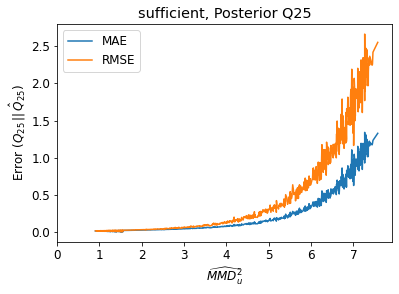

In [54]:
plot_MMD_error("sufficient", "Q25", r"Error ($Q_{25}\,||\,\hat{Q}_{25})$")

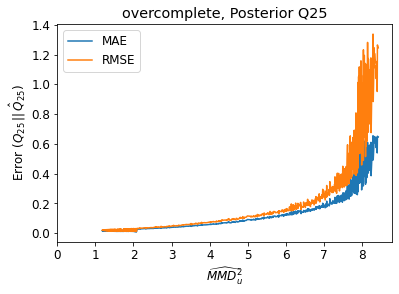

In [55]:
plot_MMD_error("overcomplete", "Q25", r"Error ($Q_{25}\,||\,\hat{Q}_{25})$")

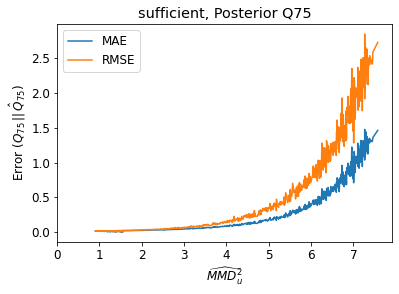

In [56]:
plot_MMD_error("sufficient", "Q75", r"Error ($Q_{75}\,||\,\hat{Q}_{75})$")

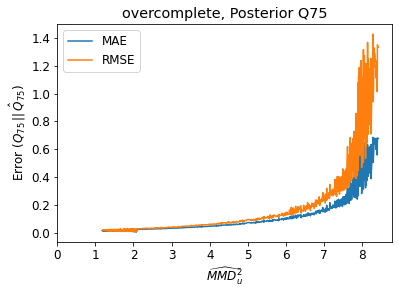

In [57]:
plot_MMD_error("overcomplete", "Q75", r"Error ($Q_{75}\,||\,\hat{Q}_{75})$")